# Heart Disease Prediction Proposal

## Introduction

It's estimated that around 110 million men and 80 million women have coronary heart disease globally, and it kills nine million people each year. In this project, we will explore the predictive variables such as age, sex, cholesterol levels, etc. We will utilize the heart disease dataset from the UC Irvine Machine Learning Repository, focusing on the Cleveland database, as it is the most complete and commonly used by ML researchers. From this data, we will classify whether the patient has heart disease and classify heart disease into four types.    

Source: https://www.bhf.org.uk/-/media/files/for-professionals/research/heart-statistics/bhf-cvd-statistics-global-factsheet.pdf

Data Source: https://archive.ics.uci.edu/dataset/45/heart+disease

## Preliminary exploratory data analysis

### Read Data
First, we load the tidyverse library and read heart disease data from the csv file. Since the data doesn't have the column name, we added the column name based on the dataset documentation.

In [1]:
library(tidyverse)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [40]:
url <- "https://raw.githubusercontent.com/wtarit/dsci-100-project/main/heart_disease_dataset/processed.cleveland.data"
heart_disease <- read_csv(url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
                                             "slope", "ca", "thal", "num"))
heart_disease

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


We can see that the data is already in tidy format, but some of the columns don't have the correct data type (chr instead of int), so we convert it to the correct datatype.

In [51]:
heart_disease <- heart_disease |> mutate(ca = as.integer(ca), thal = as.integer(thal))

We can check the distribution of data by counting a number of rows using the num column.

In [3]:
class_distribution <- heart_disease |>
    group_by(num) |> 
    summarize(count = n())
class_distribution

num,count
<dbl>,<int>
0,164
1,55
2,36
3,35
4,13


In this table, num represents heart disease, where 0 means a healthy person and 1 - 4 represents different types of heart disease. The data is quite unbalanced as there are more people without heart disease.

### Data Visualization

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.
Warning message in Ops.factor(num):
“‘-’ not meaningful for factors”
Warning message in Ops.factor(num):
“‘-’ not meaningful for factors”


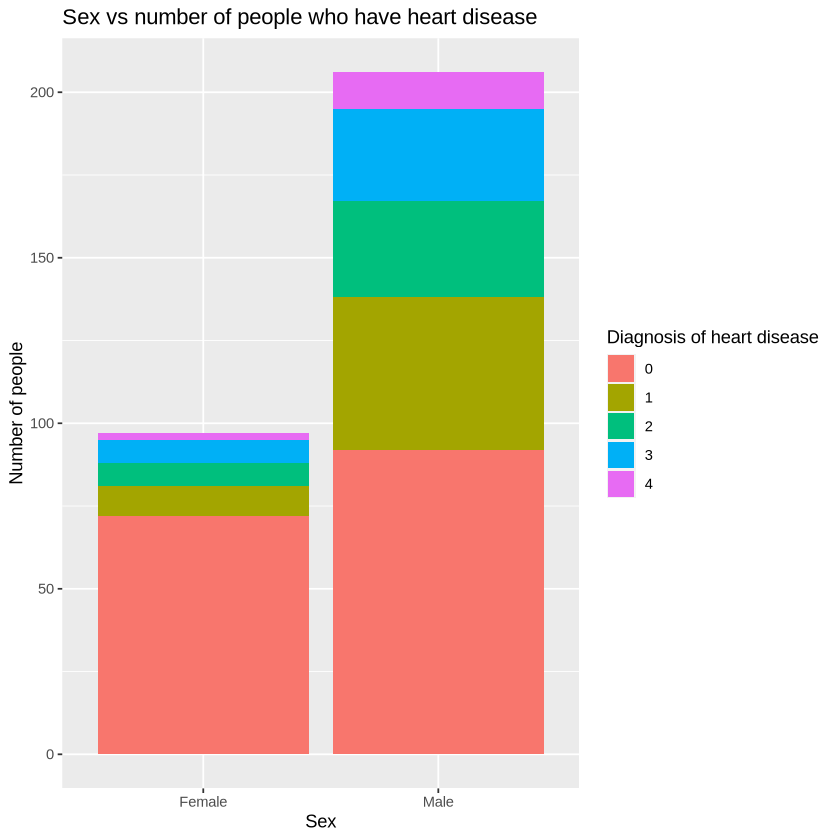

In [29]:
heart_disease_count_sex <- heart_disease |>
    group_by(sex, num) |>
    summarize(count = n()) |>
    mutate(num = as_factor(num), sex = ifelse(sex == 0, "Female", "Male"))

heart_disease_count_sex_plot <- ggplot(heart_disease_count_sex, aes(x = sex, y=count, fill = num, group = -num)) +
    geom_bar(stat = "identity", position = "stack") +
    labs(x = "Sex", y = "Number of people", fill = "Diagnosis of heart disease") +
    ggtitle("Sex vs number of people who have heart disease")

heart_disease_count_sex_plot

We can see that in the dataset, we have twice the number of data recorded for males compared to females. We also notice that there's a higher chance that we diagnosed heart disease in males. 

`summarise()` has grouped output by 'thal'. You can override using the
`.groups` argument.
Warning message in Ops.factor(num):
“‘-’ not meaningful for factors”
Warning message in Ops.factor(num):
“‘-’ not meaningful for factors”


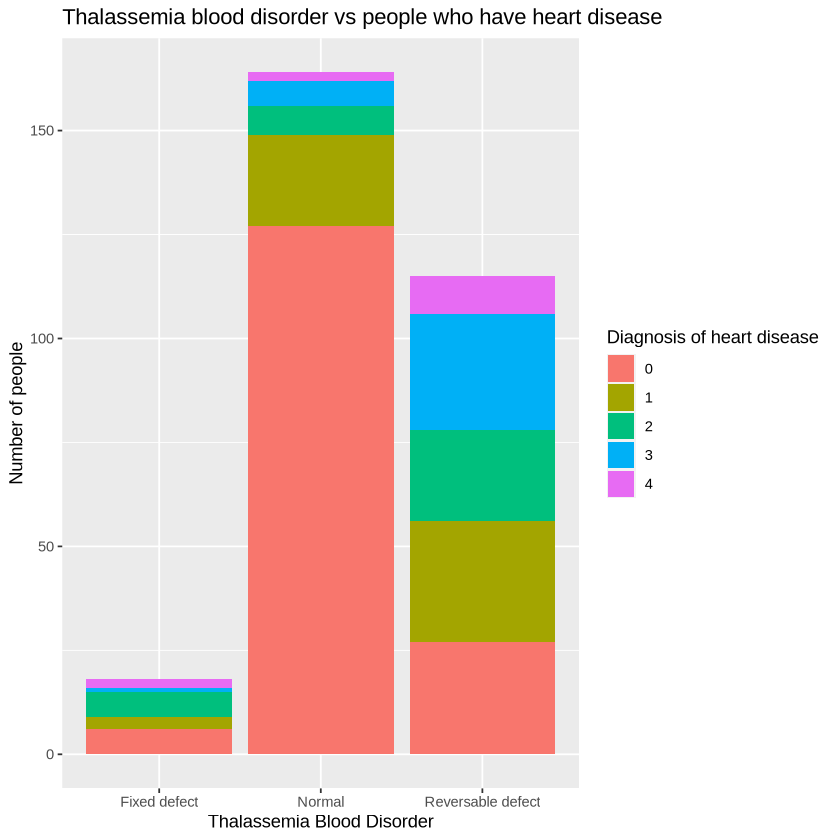

In [49]:
heart_disease_count_thal <- heart_disease |>
    drop_na() |>
    group_by(thal, num) |>
    summarize(count = n()) |>
    mutate(num = as_factor(num), thal_str = case_when(thal == 3.0 ~ "Normal", 
                                                 thal == 6.0 ~ "Fixed defect",
                                                 thal == 7.0 ~ "Reversable defect"))

heart_disease_count_thal_plot <- ggplot(heart_disease_count_thal, aes(x = thal_str, y=count, fill = num, group = -num)) +
    geom_bar(stat = "identity", position = "stack") +
    labs(x = "Thalassemia Blood Disorder", y = "Number of people", fill = "Diagnosis of heart disease") +
    ggtitle("Thalassemia blood disorder vs people who have heart disease")

heart_disease_count_thal_plot

This plot shows that people with no thalassemia blood disorder (Normal) are less likely to get heart disease.

## Methods

Firstly, we will find correlations between variables and trends that can help predict heart disease. We discovered that the main variables that affect heart disease are sex and Thalasemia blood disorder.

We will use these two main predictors and other related predictors to build a k-nearest neighbors (KNN) model for classification. To train a model, we will center the variables and scale them to ensure each predictor has a similar effect on the result. To select the optimal k value, we will use cross-validation by focusing on accuracy and recall. We want the model to correctly predict heart disease, but we also need to make sure that people who have heart disease are classified as having heart disease.

After we have the trained model, we will evaluate the model with the test dataset and measure the accuracy, precision, and recall. 

## Expected Outcomes and Significance

We expect that this model will help the medical team do an initial classification of heart disease without complicated examination. It will save time and money and increase the chance of patients getting treated.

The data analysis results could lead to future questions, such as how to minimize the factors that can cause heart disease and find a better prevention method.